In [1]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
import matplotlib as mpl
import itertools
from copy import deepcopy
from scipy.integrate import solve_ivp
from itertools import combinations_with_replacement
from src.emn_model import (
    get_clean_dataset, generate_bipartite_network, diffusion_dynamics, tree_project_network
)

In [2]:
TEX_PLOTS = False

# Plotting config
if TEX_PLOTS:
    plt.rc("text", usetex=True)
    plt.rc("font", family="serif")
    plt.rc("text.latex", preamble=r"""
         \usepackage{times}
         \usepackage{mathptmx}
         \usepackage{siunitx}""")
else:
    plt.rc("text", usetex=False)

mpl.rcParams["figure.dpi"] = 200
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["font.size"] = 14
mpl.rcParams["axes.labelsize"] = mpl.rcParams["axes.titlesize"] = 16
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["lines.linewidth"] = 1

cmap = mpl.cm.get_cmap("Dark2")
mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=cmap.colors)

np.random.seed(1231)

In [3]:
df = get_clean_dataset()
B = generate_bipartite_network(df)
G = tree_project_network(B)
pos = nx.spring_layout(G, k=3, seed=99192, weight=None)

In [4]:
N = len(G.nodes)

plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

sol = solve_ivp(diffusion_dynamics, t_range, np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                args=(G, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=True, method="BDF")

time_steps = 300
t = np.linspace(t_range[0], t_range[1], time_steps)
z = sol.sol(t)

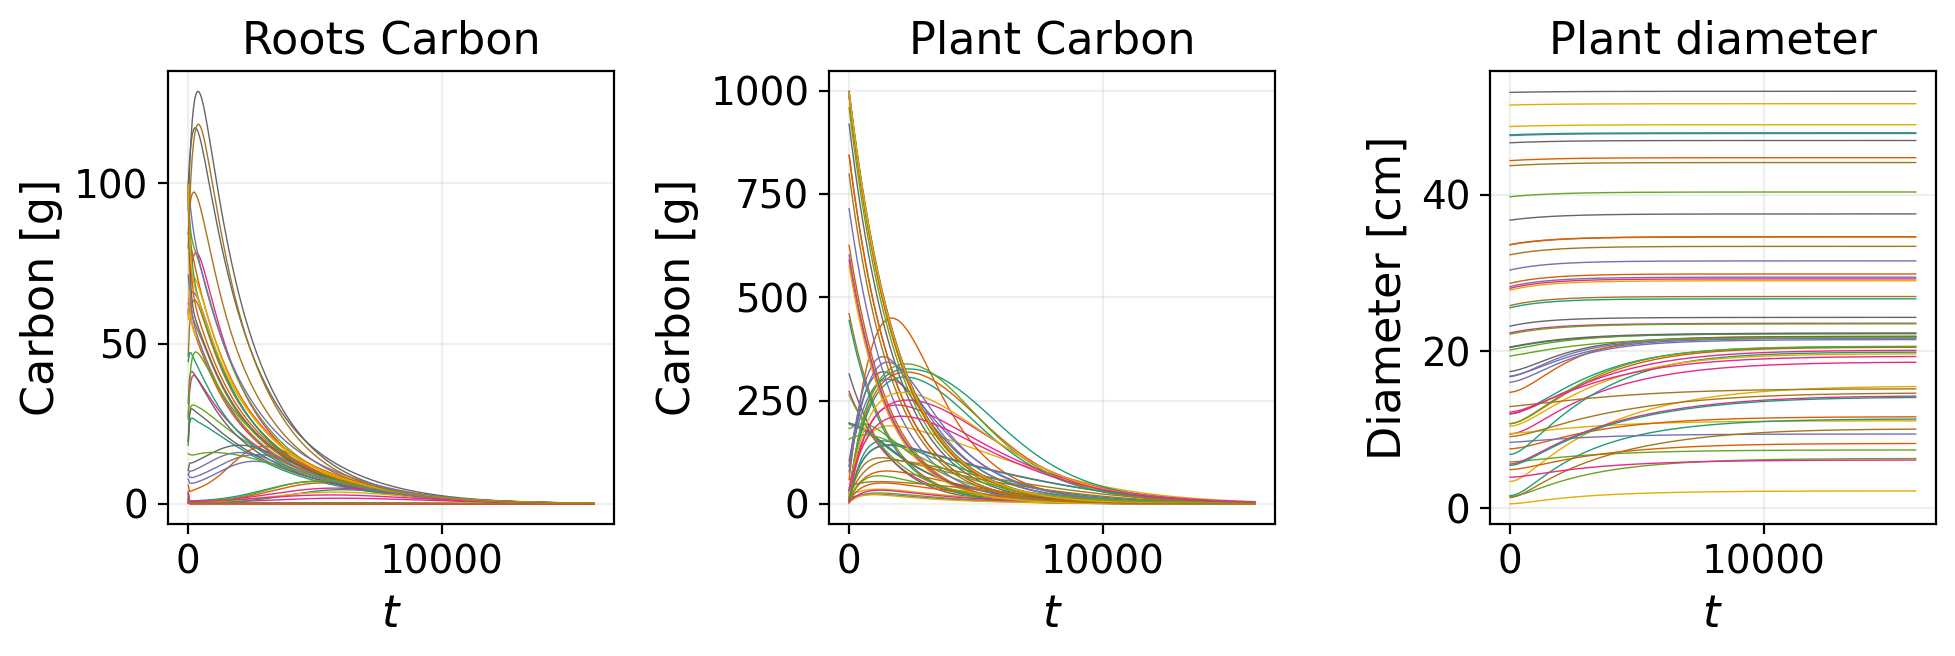

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

axes[0].set_title("Roots Carbon")
for i in range(N):
    axes[0].plot(t, z[i], linewidth=0.5)
    axes[0].set_ylabel("Carbon [g]")
    
axes[1].set_title("Plant Carbon")
for i in range(N, 2*N):
    axes[1].plot(t, z[i], linewidth=0.5)
    axes[1].set_ylabel("Carbon [g]")
    
axes[2].set_title("Plant diameter")
for i in range(2*N, 3*N):
    axes[2].plot(t, z[i], linewidth=0.5)
    axes[2].set_ylabel("Diameter [cm]")
    #axes[2].set_yscale("log")
    
for ax in axes:
    ax.set_xlabel("$t$")

plt.tight_layout()
plt.show()

In [6]:
steps = np.linspace(0, time_steps-1, 12, dtype=int)

plant_carbon_data = z[N:2*N,:]
min_carbon, max_carbon = np.min(plant_carbon_data), np.max(plant_carbon_data)

diameter_data = z[2*N:,:]
max_diameter = np.max(diameter_data)

nodes_by_cohort = {"Sapling": [], "Maturing": [], "Established": []}
node_list = list(G.nodes)

for node in G.nodes:
    nodes_by_cohort[G.nodes[node]["cohort"]].append(node)

In [7]:
def max_growth_diff(percentages):
    perms = itertools.permutations(percentages, 2)
    diffs = np.array([np.abs(a - b) for a, b in perms])

    return np.max(diffs)

In [8]:
n_edge_remove_list = np.linspace(0, len(G.edges()), 25, dtype=int)
reps = 5
remove_results = {
    k: {
        "networks": [],
        "data": []
    }
    for k in n_edge_remove_list
}
network_edges = list(G.edges)

N = len(G.nodes)
        
plant_carbon_0 = np.array(list(nx.get_node_attributes(G, "carbon_value").values()))
root_carbon_0 = 0.1 * plant_carbon_0
plant_diameter_0 = np.array(list(nx.get_node_attributes(G, "diameter").values()))

t_range = (0, 16_000)
D_C = 5.0e-4 # carbon diffusion coeff
uptake_ps = (0.55, 0.0, 55.0)
f = 5.0e-4 # sensitive w.r.t plant carbon deposition
k = 0.6
g = 0.004
c = 0.82
rho = 0.01

for j, n_edge_remove in enumerate(n_edge_remove_list):
    print(f"N {j+1}/{len(n_edge_remove_list)}")
    for i in range(reps):
        G_r = deepcopy(G)
        edges_idx = np.random.choice(len(network_edges), size=n_edge_remove, replace=False)
        
        G_r.remove_edges_from([network_edges[edge_idx] for edge_idx in edges_idx])
        remove_results[n_edge_remove]["networks"].append(G_r)
        
        sol = solve_ivp(diffusion_dynamics, t_range,
                        np.concatenate([root_carbon_0, plant_carbon_0, plant_diameter_0]),
                        args=(G_r, D_C, N, uptake_ps, f, k, c, g, rho), dense_output=False, method="BDF",
                        t_eval=t_range)
        remove_results[n_edge_remove]["data"].append(sol.y)

N 1/25
N 2/25
N 3/25
N 4/25
N 5/25
N 6/25
N 7/25
N 8/25
N 9/25
N 10/25
N 11/25
N 12/25
N 13/25
N 14/25
N 15/25
N 16/25
N 17/25
N 18/25
N 19/25
N 20/25
N 21/25
N 22/25
N 23/25
N 24/25
N 25/25


In [9]:
x = []
ys = {k : [] for k in ["Sapling", "Maturing", "Established"]}
errs = {k : [] for k in ["Sapling", "Maturing", "Established"]}

for n, data in remove_results.items():
    avg_degree = np.mean(list(dict(data["networks"][0].degree()).values()))
    x.append(avg_degree)
    for cohort, nodes in nodes_by_cohort.items():
        node_idxs = [node_list.index(node) for node in nodes]
        
        growth_percentages = []
        for run in data["data"]:
            diameter_data_run = run[2*N:,:]
            growth = diameter_data_run[node_idxs,-1] - diameter_data_run[node_idxs,0]
            growth_percentages.append(growth)

        concat_growth = np.concatenate(growth_percentages)
        
        ys[cohort].append(np.mean(concat_growth))
        errs[cohort].append(np.std(concat_growth)/np.sqrt(np.size(concat_growth)))

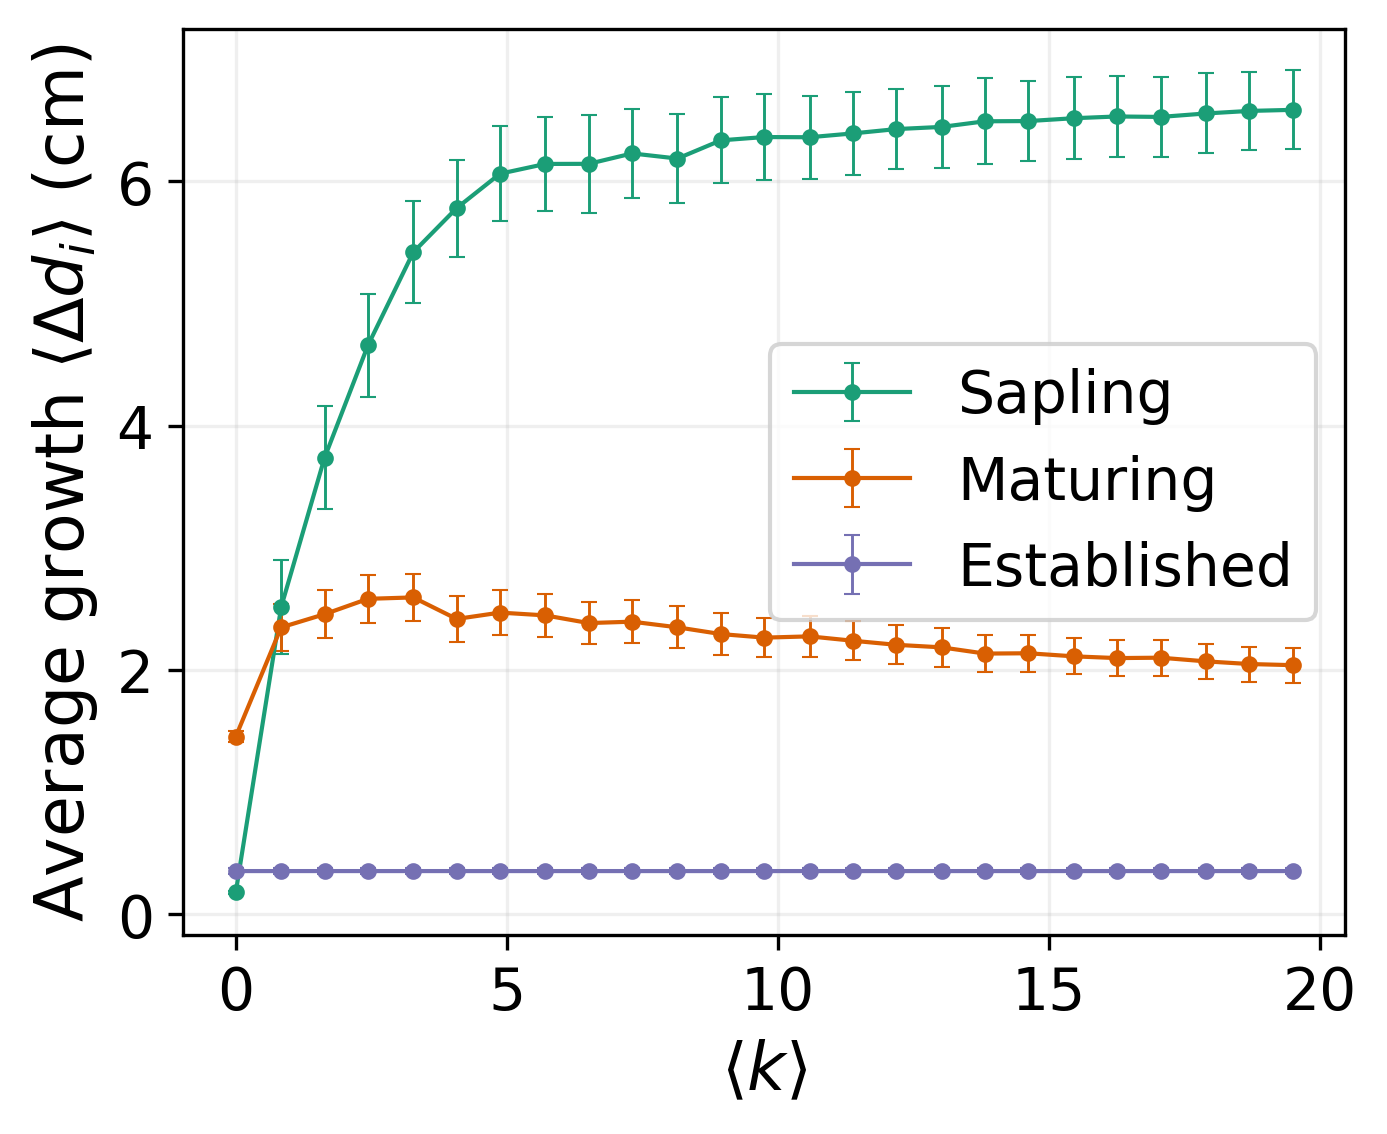

In [10]:
plt.figure(figsize=(5, 4), dpi=300)

for k in ys.keys():
    plt.errorbar(x, ys[k], errs[k], marker="o", ms=3, elinewidth=0.7, capthick=0.5, capsize=2, label=f"{k}")
    
plt.legend()
plt.xlabel(r"$\langle k \rangle$")
plt.ylabel(r"Average growth $\langle \Delta d_i \rangle$ (cm)")

if TEX_PLOTS:
    plt.savefig("figures/avg_diam_change_avg_k.png", bbox_inches="tight")
    
plt.show()

In [11]:
surv_ys = {k : [] for k in ["Sapling", "Maturing", "Established"]}
surv_errs = {k : [] for k in ["Sapling", "Maturing", "Established"]}

for n, data in remove_results.items():
    cohort = "Sapling"
    nodes = nodes_by_cohort[cohort]

    node_idxs = [node_list.index(node) for node in nodes]

    n_survivors_all = []
    for run in data["data"]:
        diameter_data_run = run[2*N:,:]
        growth_frac = diameter_data_run[node_idxs,-1]/diameter_data_run[node_idxs,0]
        n_survivors = len(np.where(growth_frac >= 2)[0])
        n_survivors_all.append(n_survivors)
    n_survivors_all = np.array(n_survivors_all)

    surv_ys[cohort].append(np.mean(n_survivors_all))
    surv_errs[cohort].append(np.std(n_survivors_all)/np.sqrt(np.size(n_survivors_all)))

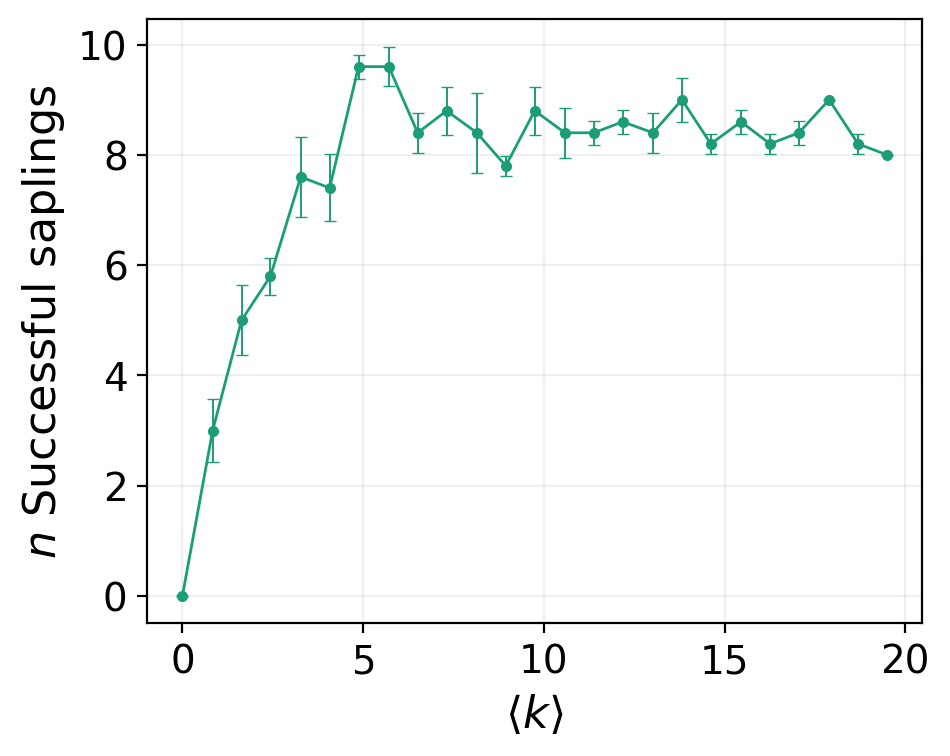

In [12]:
plt.figure(figsize=(5, 4))

plt.errorbar(x, surv_ys["Sapling"], surv_errs["Sapling"], marker="o", ms=3, elinewidth=0.7, capthick=0.5, capsize=2)
    
plt.xlabel(r"$\langle k \rangle$")
plt.ylabel(r"$n$ Successful saplings")
if TEX_PLOTS:
    plt.savefig("figures/avg_successful_avg_k.png", bbox_inches="tight")
plt.show()

Cohort Sapling grew on average 6.586200114764974 cm
Cohort Sapling grew on average 251.92272867681126% +- 169.98556084296507
Cohort Sapling max growth difference (competition) 628.5246279229016%


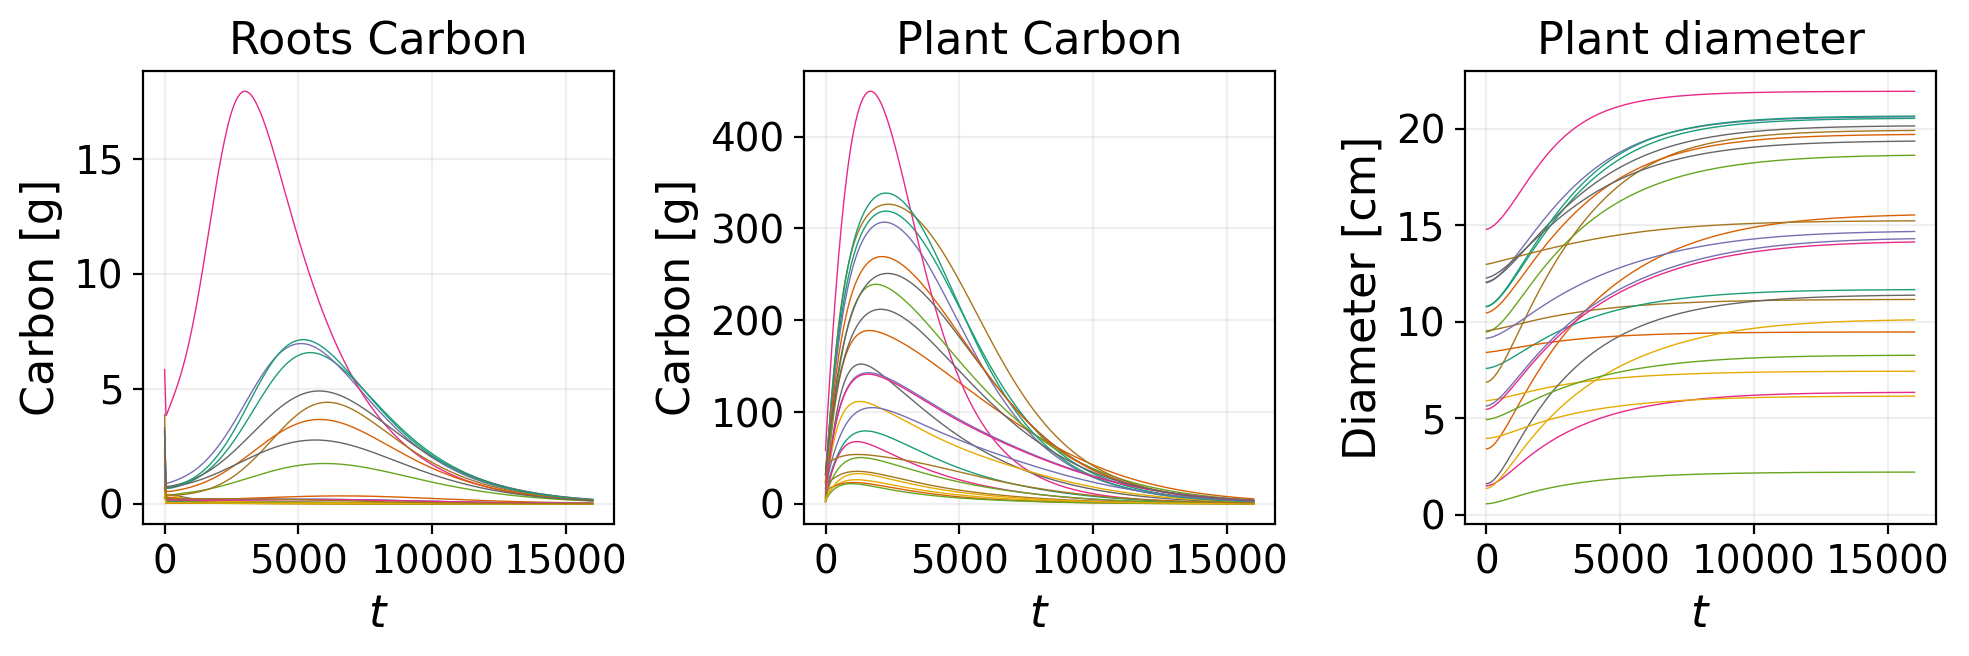

Cohort Maturing grew on average 2.0394975109218776 cm
Cohort Maturing grew on average 110.16525732731849% +- 9.767941753536185
Cohort Maturing max growth difference (competition) 30.955145487576715%


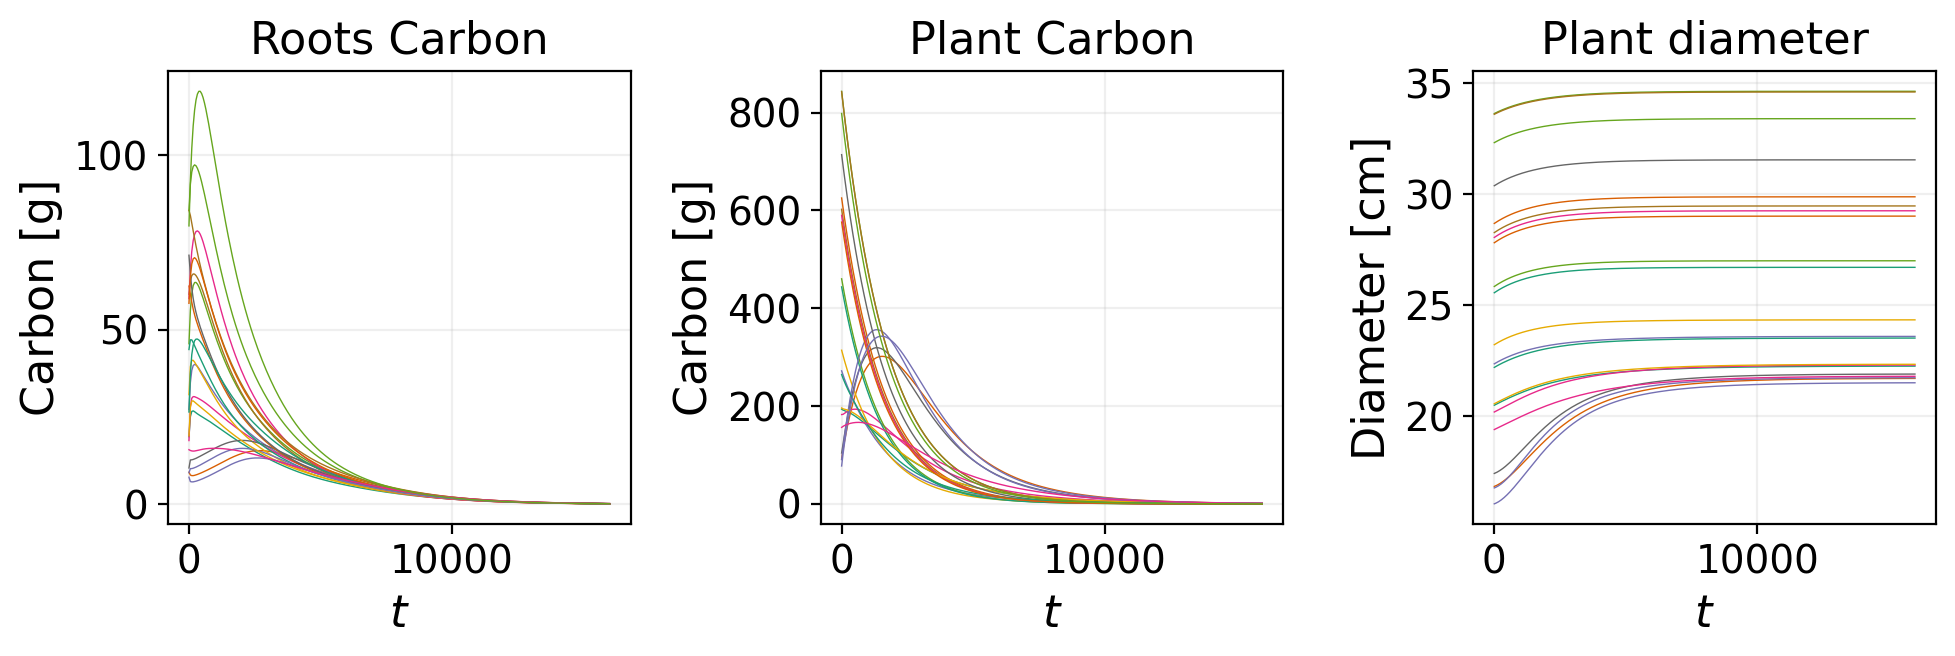

Cohort Established grew on average 0.3535167312177968 cm
Cohort Established grew on average 100.82483146381901% +- 0.5615088930557507
Cohort Established max growth difference (competition) 1.8970465397138412%


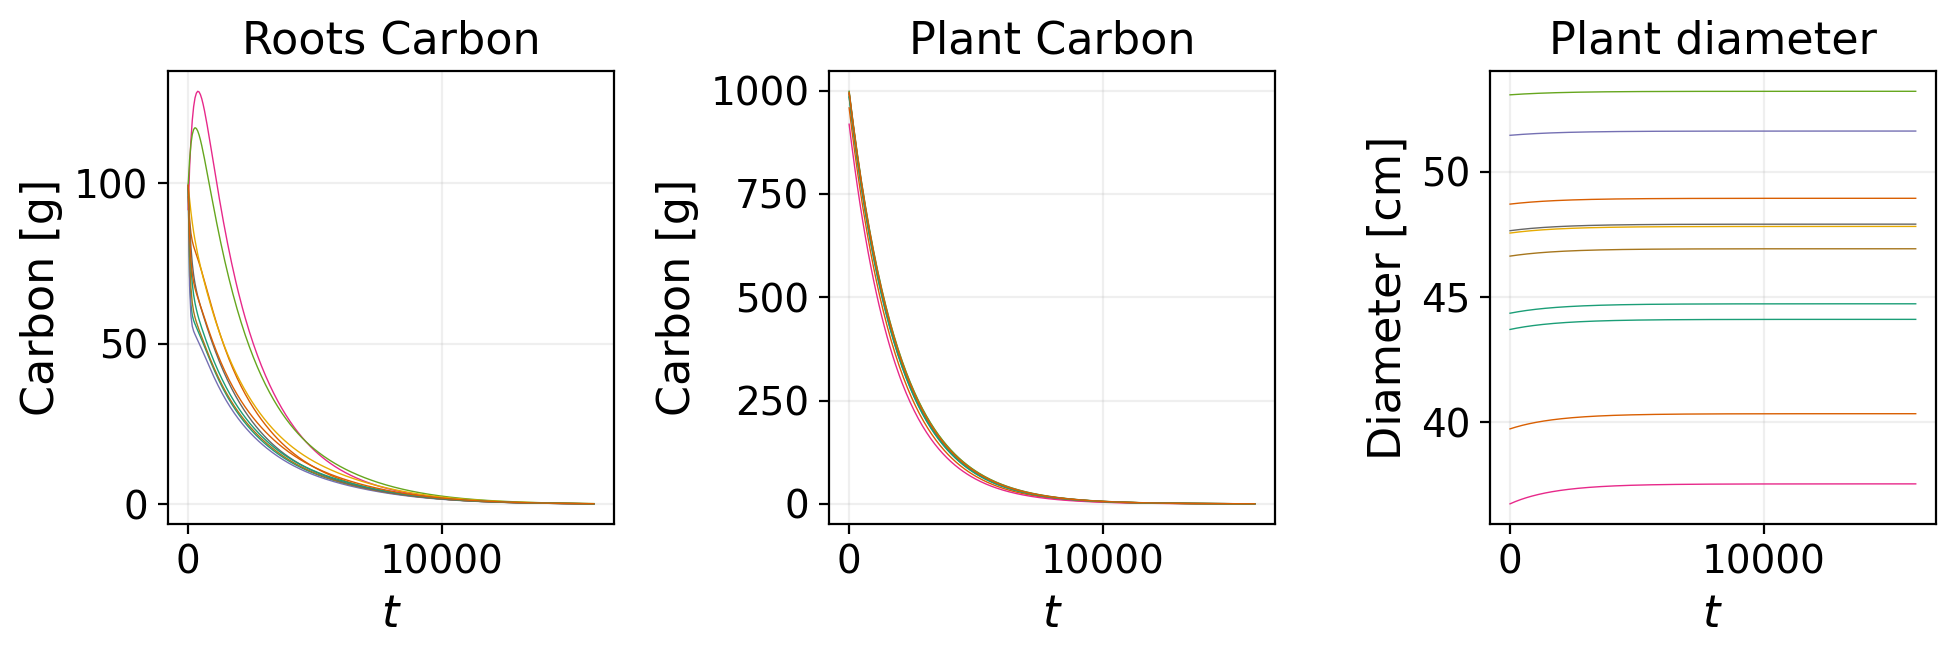

In [13]:
for cohort, nodes in nodes_by_cohort.items():
    node_idxs = [node_list.index(node) for node in nodes]
    growth = diameter_data[node_idxs, -1] - diameter_data[node_idxs, 0]
    avg_growth = np.mean(growth)
    percentages = diameter_data[node_idxs, -1]/diameter_data[node_idxs, 0]*100
    percentage_mean = np.mean(percentages)
    percentage_stdev = np.std(percentages)

    print(f"Cohort {str(cohort)} grew on average {avg_growth} cm")
    print(f"Cohort {str(cohort)} grew on average {percentage_mean}% +- {percentage_stdev}")
    
    if cohort != 1:
        growth_diff = max_growth_diff(percentages)
        print(f"Cohort {str(cohort)} max growth difference (competition) {growth_diff}%")
        
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), dpi=200)

    roots_carbon_data = z[:N,:]
    plant_carbon_data = z[N:2*N,:]

    axes[0].set_title("Roots Carbon")
    axes[0].plot(t, roots_carbon_data[node_idxs, :].T, linewidth=0.5)
    axes[0].set_xlabel("$t$")
    axes[0].set_ylabel("Carbon [g]")

    axes[1].set_title("Plant Carbon")
    axes[1].plot(t, plant_carbon_data[node_idxs, :].T, linewidth=0.5)
    axes[1].set_xlabel("$t$")
    axes[1].set_ylabel("Carbon [g]")

    axes[2].set_title("Plant diameter")
    axes[2].plot(t, diameter_data[node_idxs, :].T, linewidth=0.5)
    axes[2].set_xlabel("$t$")
    axes[2].set_ylabel("Diameter [cm]")
    # axes[2].set_yscale("log")

    plt.tight_layout()
    plt.show()